# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

# 2 ЗАДАНИЕ

In [0]:
import collections
import math
import os
import random
import zipfile
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim 
import torch.nn.functional
import time
import requests
from os.path import isfile
import numpy as np
from six.moves import urllib
from six.moves import xrange
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import OrderedDict
from operator import itemgetter 
import torch.nn.functional as func

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [4]:
if not os.path.isfile('text8'):# downloading corpus
    with open('data.zip', 'wb') as f:
        r = requests.get('http://mattmahoney.net/dc/text8.zip')
        f.write(r.content)
    !unzip 'data.zip' 

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = (f.read(f.namelist()[0]).split())
        data = list(map(lambda x: x.decode(), data))
    return data
with open('text8') as f:
    words = f.read().split()

Archive:  data.zip
  inflating: text8                   


In [0]:
voc_size = 15000
UNK_TOKEN = 'TOKEN'# для редких слов
frequency = collections.Counter(words)# словарь всех слов
freq = frequency.most_common(voc_size)# словарь частых слов
low_bound = freq[-1][1]# наименьшее количество повторений для попадания в словарь частых
vocab = [x[0] for x in freq]# список слов из словаря
vocab = [UNK_TOKEN] + vocab
word_index = {w: idx for (idx, w) in enumerate(vocab)}# слово - индекс
index_word = {idx: w for (idx, w) in enumerate(vocab)}# индекс - слово
data = []# индексы words
for word in words:
  if frequency[word] > low_bound:
    data.append(word_index[word])
  else:
    data.append(0)

In [0]:
class Batcher():
  def __init__(self, data, window_size, batch_size=20):
    self.window_size = window_size
    self.batch_size = batch_size
    self.data = data
    self.span = 2 * window_size + 1
  def make(self):
    label_ind = []
    label = []
    batch = []
    for i in range(self.batch_size):# создаем список центральных слов
      index = int(np.random.uniform(0,len(self.data)))
      if index == 0 or (len(words) - index - 1 <self.window_size):
                index = self.window_size
      label_ind.append(index)
    for ind in label_ind:# создаем их контексты
      label.append(self.data[ind])
      list_ = [i for i in range(-self.window_size, self.window_size+1) if i!=0]
      b = [self.data[ind+i] for i in list_]
      batch.append(b)
    return batch, label

In [0]:
def one_hot(batch, voc_size, window_size, batch_size):
  result = torch.zeros([batch_size, voc_size])
  for i,cont in enumerate(batch):
    for j in cont:
      result[i,j] = result[i,j] + 1# from each context we get one_hot vector
  return result

# 3 ЗАДАНИЕ

In [0]:
class my_model(nn.Module):# linear + relu + linear - CBOW
    def __init__(self, window_size, voc_size, batch_size, hidden_size):
        super().__init__()
        self.input_shape = voc_size
        self.hidden_size = hidden_size
        self.lin1 = nn.Linear(self.input_shape, self.hidden_size)
        self.lin2 = nn.Linear(self.hidden_size, self.input_shape)
    def forward(self, x):
        x = self.lin1(x)
        x = func.relu(x)
        x = self.lin2(x)
        x = func.log_softmax(x, dim=1)
        return x

In [0]:
window_size = 3
batch_size = 200
learning_rate = 1
hidden_size = 200

In [0]:
start_time = time.clock()
loss_function = nn.NLLLoss()
model = my_model(window_size = window_size, voc_size =voc_size, batch_size = batch_size, hidden_size = hidden_size)
loss = torch.tensor(0)
batcher = Batcher(data, window_size, batch_size)
model = my_model(window_size = window_size, voc_size = voc_size, batch_size = batch_size, hidden_size = hidden_size)# модель 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#оптимизатор

In [0]:
x = []# для графика
y = []

In [12]:
start_time = time.clock()
losses = []
for epoch in range(1000):# обучение сети
  batch, label = batcher.make()
  batch_onehot = one_hot(batch, voc_size, window_size, batch_size)
  # Zero out all of the gradients for the variables which the optimizer will update.
  model.zero_grad()
  log_probs = model(batch_onehot)
  loss = loss_function(log_probs, torch.tensor(label, dtype=torch.long))
  # This is the backwards pass: compute the gradient of the loss with respect to each  parameter of the model.
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  if epoch % 100 == 0:
    s = 0
    for i in losses:
      s+= i
    x.append(epoch)
    y.append(s)
    print('epoch %d,' %epoch,'\tloss %lg' %s)
    print('time passed %d:' %(time.clock()-start_time))
  losses = []  

epoch 0, 	loss 9.61986
time passed 0:
epoch 100, 	loss 7.08715
time passed 17:
epoch 200, 	loss 6.84437
time passed 34:
epoch 300, 	loss 6.57927
time passed 51:
epoch 400, 	loss 6.31147
time passed 69:
epoch 500, 	loss 6.70858
time passed 86:
epoch 600, 	loss 6.7418
time passed 103:
epoch 700, 	loss 6.27671
time passed 120:
epoch 800, 	loss 6.19811
time passed 137:
epoch 900, 	loss 6.40982
time passed 154:


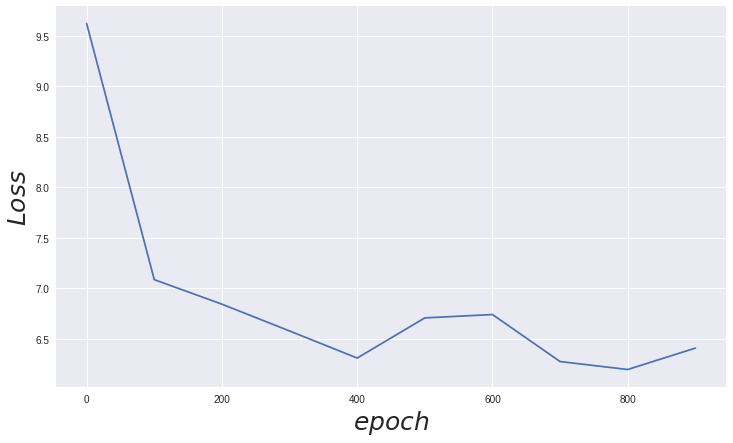

In [13]:
plt.figure(figsize=(12,7))
plt.plot(x, y)
plt.xlabel("$epoch$", fontsize=25)
plt.ylabel("$Loss$", fontsize=25)
plt.show()

## Нарисуем диаграму

In [0]:
modules = enumerate(model.modules())# take first layer
next(modules)
layer = next(modules)[1]

In [0]:
def plot_with_labels(low_dim_embs, labels, filename='fig.png'):# plotting
    plt.figure(figsize=(15, 15))
    for it, label in enumerate(labels):
        x, y = low_dim_embs[it, :]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points')
    plt.savefig(filename)

In [0]:
def t(batch, voc_size):
  batch_onehot = torch.zeros(len(batch), voc_size)
  for i,_ in enumerate(batch):
    if type(batch[i])!= type(0):
      for y in batch[i]:
        batch_onehot[i, y] = batch_onehot[i, y] + 1
    else:
      batch_onehot[i, batch[i]] = 1
  return batch_onehot

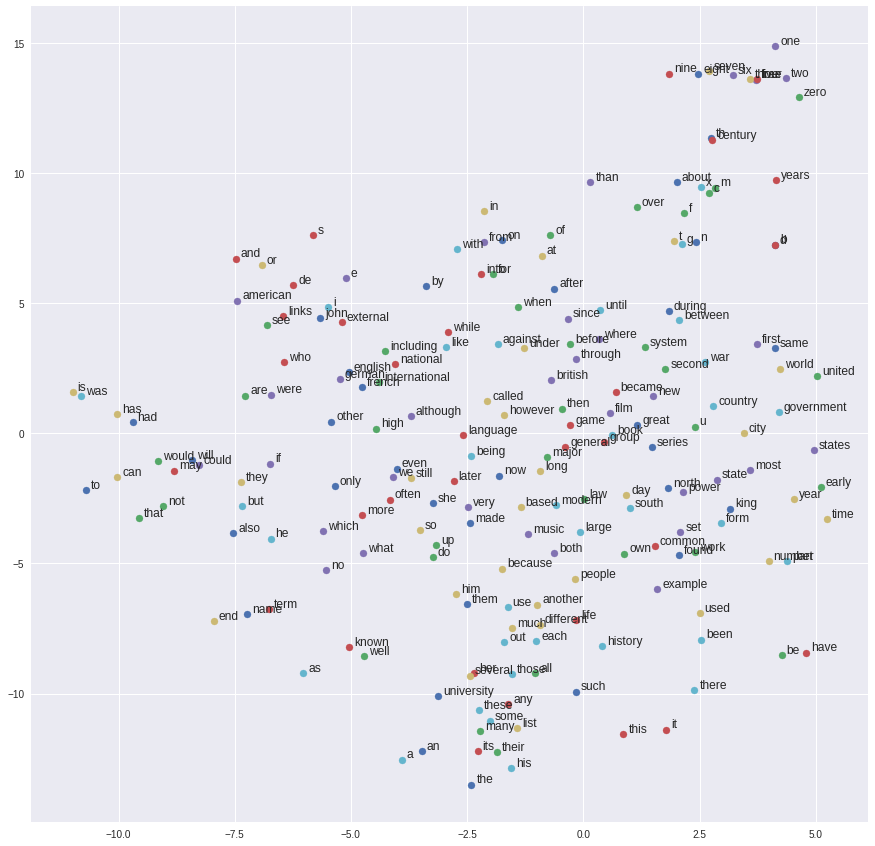

In [18]:
tsne = TSNE(n_components=2, init='pca', n_iter=10000)
plot_only = 200
final_embeddings = [layer(t([word_index[x[0]]], voc_size)).detach().numpy()[0] for x in frequency.most_common(plot_only)]
low_dim_embs = tsne.fit_transform(np.array(final_embeddings))
labels = [x[0] for x in frequency.most_common(plot_only)]
plot_with_labels(low_dim_embs, labels)

## Найдем ближайших соседей 

In [0]:
def get_vector_for_word(word):#way to get a word vector
  return layer(t([word_index[word]],voc_size))

In [0]:
def cosine(w1,w2,layer):
  vec1 = get_vector_for_word(w1)
  vec2 = get_vector_for_word(w2)
  return ((vec1[0].dot(vec2[0]))/(torch.norm(vec1[0])*torch.norm(vec2[0]))).item()

In [0]:
def neighbours(word, vocabulary, linear, number=5): # NEAREST NEIGBOURS
  voc = {}# слово - кос. мера
  for i in vocabulary[0:14999]:
    voc[i[0]] = cosine(word,i[0],layer)
  voc =  OrderedDict(sorted(voc.items(), key = itemgetter(1), reverse = True))
  l = list(voc.items())
  result = []
  for i in range(1, number):
    result.append(l[i][0])
  return result

In [30]:
print(neighbours('seven',freq, layer))

['eight', 'six', 'three', 'five']


In [34]:
print(neighbours('king',freq, layer, number = 20))

['council', 'president', 'republic', 'majority', 'battle', 'department', 'development', 'head', 'community', 'forces', 'study', 'israel', 'theory', 'main', 'god', 'creation', 'consists', 'aspects', 'kingdom']


In [33]:
print(neighbours('war',freq, layer))

['second', 'union', 'following', 'sea']
